## Import Necessary Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
path  = '/ocean/projects/atm200007p/'
e3sm  = np.squeeze(xr.open_dataset(path+'sferrett/e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5  = xr.open_dataset(path+'sferrett/era5/ERA5_2D_195906_202108_monthly.nc')
era5  = era5.reindex(latitude=era5.latitude[::-1]).rename({'longitude':'lon','latitude':'lat'})
imerg = xr.open_mfdataset(np.sort(glob.glob(path+'nanaliu/imerg/'+'*.nc4'))).transpose('time','lat','lon')

In [3]:
coords = [pd.date_range('1950-01-01','2021-12-01',freq='MS')]
def createindexdataset(filename,a,b):
    with open(path+'sferrett/indices/'+filename) as file: datafile=file.readlines()
    datalist = []
    for line in datafile[a:b]:datalist.append(line.strip().split())
    file.close()
    data = np.asarray(datalist)[:,1:].reshape(864,)
    dataset = xr.DataArray(data,coords=coords,dims='time').astype('float16')
    return dataset
dmi = createindexdataset('DMI_West_1870_2022.txt',81,-8)
oni = createindexdataset('ONI_1950_2022.txt',1,-9)

## Standardize Data and Define Variables

In [4]:
def formatindices(index):
    data = xr.concat((index[5::12],index[6::12],index[7::12]),dim='time').to_numpy().reshape(3,72)
    databymonth = xr.DataArray(data).rename({'dim_0':'month','dim_1':'year'})
    return databymonth
era5dmi = formatindices(dmi)
era5dmi,imergdmi = formatindices(dmi)[:,9:],formatindices(dmi)[:,50:]
era5oni,imergoni = formatindices(oni)[:,9:],formatindices(oni)[:,50:]

In [5]:
lat1=10; lat2=20; lon1=50; lon2=90; era5years=63; imergyears=22
months=['JUN','JUL','AUG']; names=['ERA5 (1959 - 2021)','IMERG (2000 - 2021)']; 
z   = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
lon = e3sm.lon.sel(lon=slice(lon1,lon2))
def varprofile(vardata):
    lonslice = vardata.lon.sel(lon=slice(lon1,lon2)).to_numpy()
    varslice = vardata.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)).mean(dim='lat').to_numpy()
    transform = interpolate.interp1d(lonslice,varslice,bounds_error=False)
    data = xr.DataArray(transform(e3sm.lon.sel(lon=slice(lon1,lon2)))).rename({'dim_0':'time','dim_1':'lon'})
    if len(data.time) == 189:
        databymonth = xr.concat((data[0::3],data[1::3],data[2::3]),dim='month').rename({'time':'year'})
    if len(data.time) == 256:
        databymonth = xr.concat((data[0::12],data[1::12],data[2::12]),dim='month').rename({'time':'year'})
    return databymonth
era5pr  = varprofile(era5.mtpr*86400)
imergpr = varprofile(imerg.precipitation*24)

## Plot Time Series of ENSO and IOD Indices

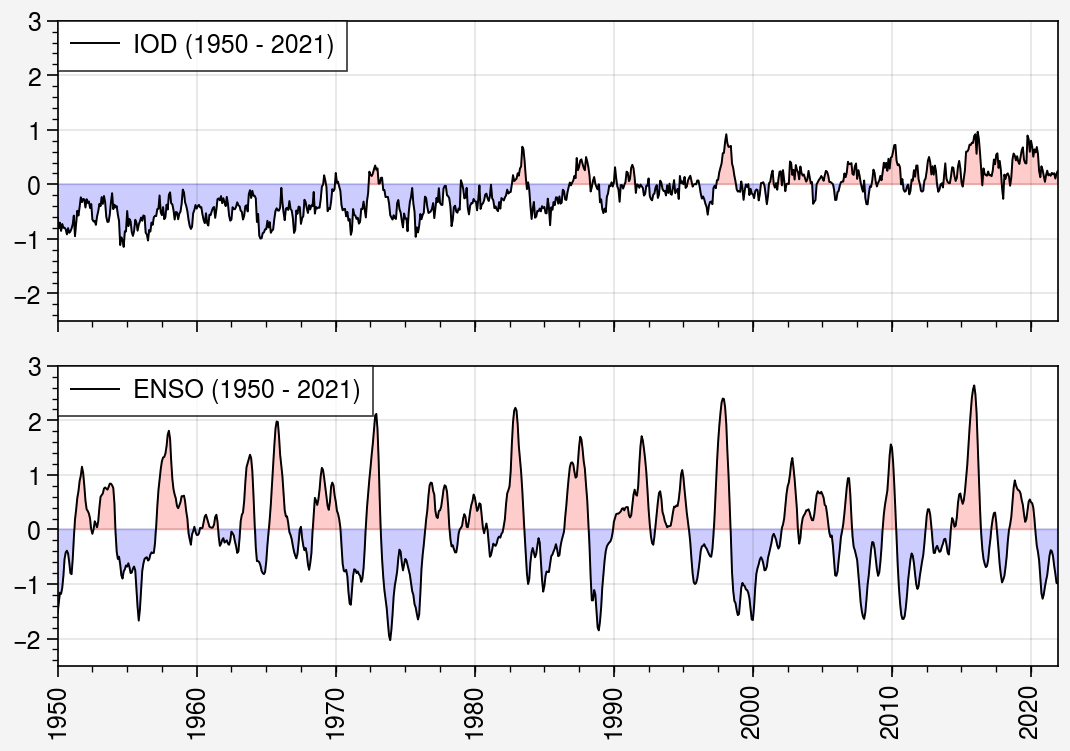

In [6]:
pplt.rc.reso='hi'; alpha=0.2; linewidth=0.7
fig,axs = pplt.subplots(ncols=1,nrows=2,refheight=1.5,refwidth=5,sharex=True,sharey=True)
axs.format(xlabel='',ylim=(-2.5,3))
axs[0].plot(dmi.time,dmi,'k',linewidth=linewidth,label='IOD (1950 - 2021)')
axs[0].fill_between(dmi.time,dmi,where=dmi>0,color='r',alpha=alpha)
axs[0].fill_between(dmi.time,dmi,where=dmi<0,color='b',alpha=alpha)
axs[0].legend(loc='ul')
axs[1].plot(oni.time,oni,'k',linewidth=linewidth,label='ENSO (1950 - 2021)')
axs[1].fill_between(oni.time,oni,where=oni>0,color='r',alpha=alpha)
axs[1].fill_between(oni.time,oni,where=oni<0,color='b',alpha=alpha)
axs[1].legend(loc='ul')

## Plot Upwind Profiles of Precipitation for ERA5

In [7]:
era5meddmi = xr.zeros_like(era5pr)
era5posdmi = xr.zeros_like(era5pr)
era5negdmi = xr.zeros_like(era5pr)
era5medoni = xr.zeros_like(era5pr)
era5posoni = xr.zeros_like(era5pr)
era5negoni = xr.zeros_like(era5pr)
for i,month in enumerate(months):
    for j in range(era5years):
        era5meddmi[i,j] = era5pr[i,j].where(-0.25<era5dmi[i,j]<0.25)
        era5posdmi[i,j] = era5pr[i,j].where(era5dmi[i,j]>=0.25)    
        era5negdmi[i,j] = era5pr[i,j].where(era5dmi[i,j]<=-0.25)
        era5medoni[i,j] = era5pr[i,j].where(-0.5<era5oni[i,j]<0.5)
        era5posoni[i,j] = era5pr[i,j].where(era5oni[i,j]>=0.5)     
        era5negoni[i,j] = era5pr[i,j].where(era5oni[i,j]<=-0.5)    

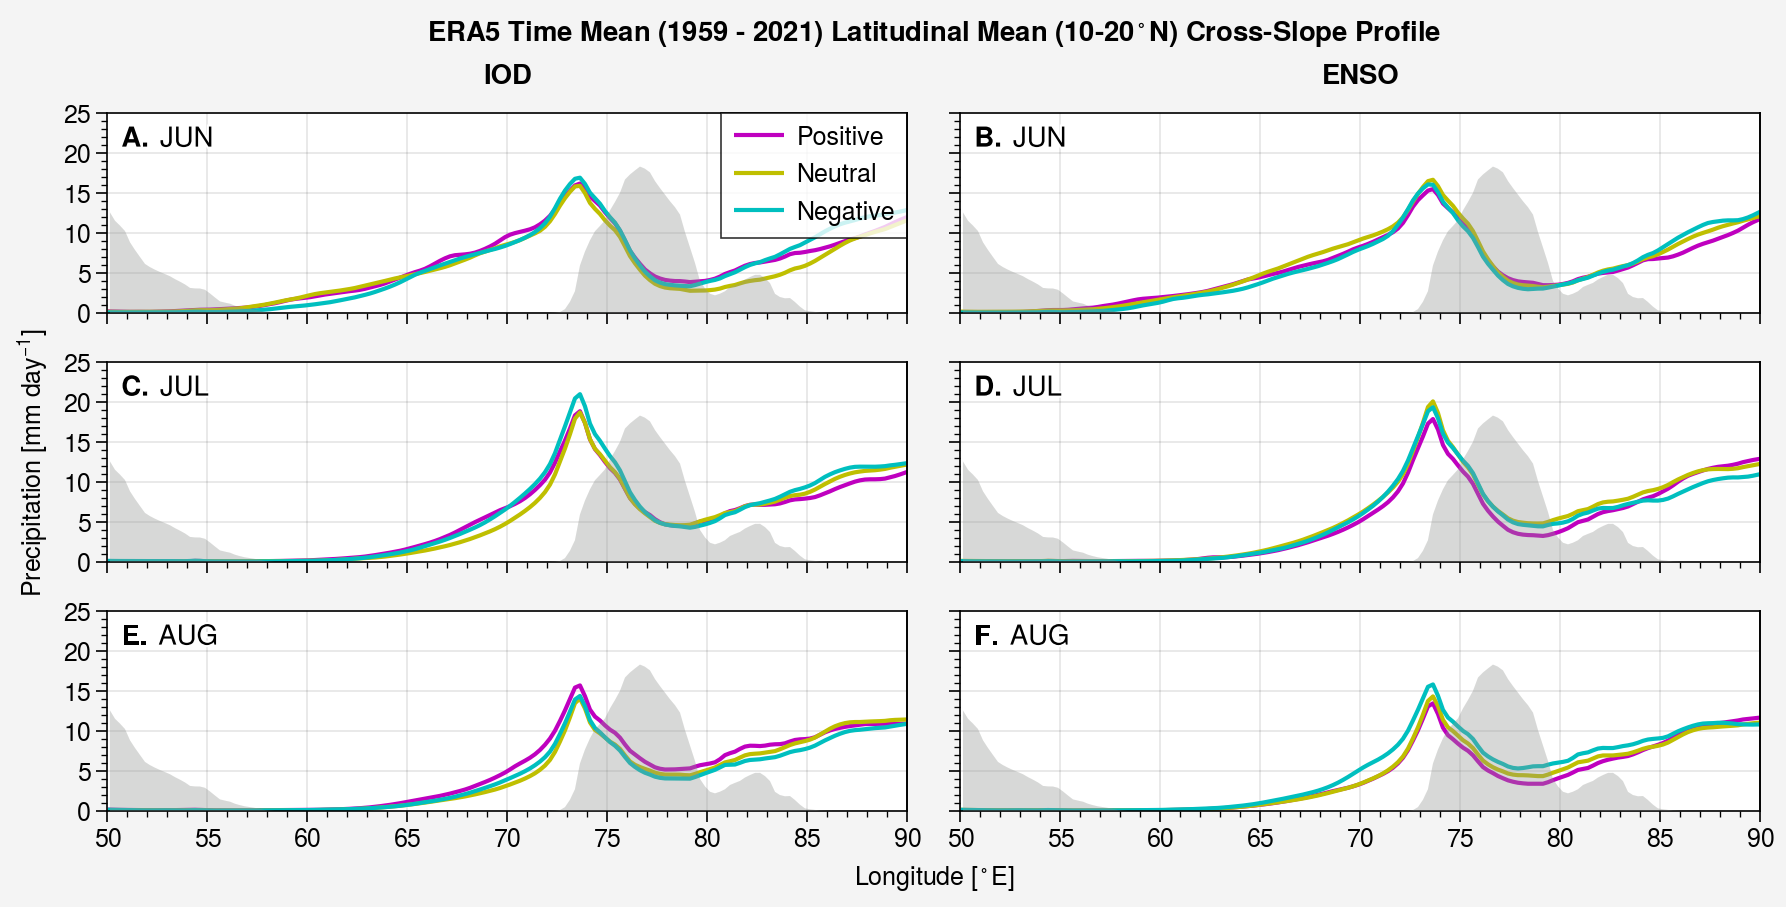

In [8]:
pplt.rc.reso='hi'
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle='ERA5 Time Mean (1959 - 2021) Latitudinal Mean ('
           +str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='ul',titleloc='ul',collabels=['IOD','ENSO'],
           xlabel='Longitude [$^\circ$E]',xlim=(50,90),xticks=5,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,25),yticks=5) 
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,ax in enumerate(months):     
    m = axs[2*i].plot(lon,era5posdmi[i].mean(dim='year'),colors='m',label='Positive')
    y = axs[2*i].plot(lon,era5meddmi[i].mean(dim='year'),colors='y',label='Neutral')    
    c = axs[2*i].plot(lon,era5negdmi[i].mean(dim='year'),colors='c',label='Negative')        
    axs[2*i].format(title=months[i])  
    axs[2*i+1].plot(lon,era5posoni[i].mean(dim='year'),colors='m')
    axs[2*i+1].plot(lon,era5medoni[i].mean(dim='year'),colors='y')
    axs[2*i+1].plot(lon,era5negoni[i].mean(dim='year'),colors='c') 
    axs[2*i+1].format(title=months[i]) 
axs[0].legend((m,y,c),loc='ur',ncols=1)

## Plot Upwind Profiles of Precipitation for IMERG

In [9]:
imergmeddmi = xr.zeros_like(imergpr)
imergposdmi = xr.zeros_like(imergpr)
imergnegdmi = xr.zeros_like(imergpr)
imergmedoni = xr.zeros_like(imergpr)
imergposoni = xr.zeros_like(imergpr)
imergnegoni = xr.zeros_like(imergpr)
for i,month in enumerate(months):
    for j in range(imergyears):
        imergmeddmi[i,j] = imergpr[i,j].where(-0.25<imergdmi[i,j]<0.25)
        imergposdmi[i,j] = imergpr[i,j].where(imergdmi[i,j]>=0.25)     
        imergnegdmi[i,j] = imergpr[i,j].where(imergdmi[i,j]<=-0.25)
        imergmedoni[i,j] = imergpr[i,j].where(-0.5<imergoni[i,j]<0.5)
        imergposoni[i,j] = imergpr[i,j].where(imergoni[i,j]>=0.5)      
        imergnegoni[i,j] = imergpr[i,j].where(imergoni[i,j]<=-0.5)

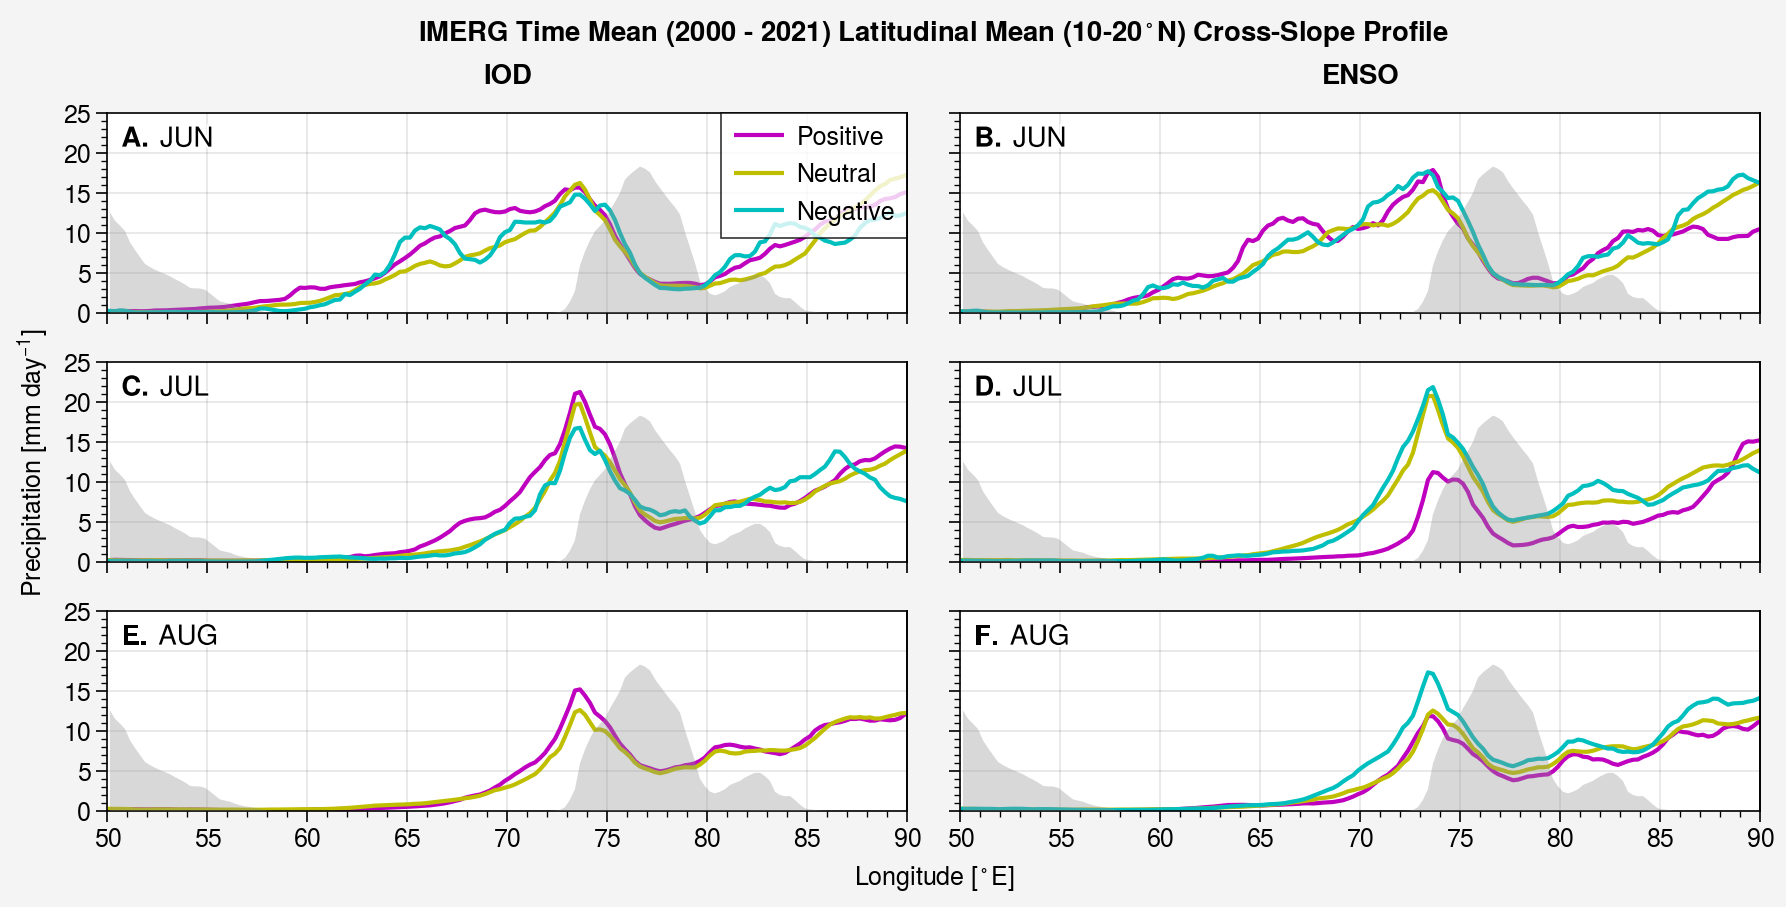

In [10]:
pplt.rc.reso='hi'
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle='IMERG Time Mean (2000 - 2021) Latitudinal Mean ('
           +str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='ul',titleloc='ul',collabels=['IOD','ENSO'],
           xlabel='Longitude [$^\circ$E]',xlim=(50,90),xticks=5,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,25),yticks=5) 
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,ax in enumerate(months):     
    m = axs[2*i].plot(lon,imergposdmi[i].mean(dim='year'),colors='m',label='Positive')
    y = axs[2*i].plot(lon,imergmeddmi[i].mean(dim='year'),colors='y',label='Neutral')    
    c = axs[2*i].plot(lon,imergnegdmi[i].mean(dim='year'),colors='c',label='Negative')     
    axs[2*i].format(title=months[i])  
    axs[2*i+1].plot(lon,imergposoni[i].mean(dim='year'),colors='m')
    axs[2*i+1].plot(lon,imergmedoni[i].mean(dim='year'),colors='y')
    axs[2*i+1].plot(lon,imergnegoni[i].mean(dim='year'),colors='c') 
    axs[2*i+1].format(title=months[i]) 
axs[0].legend((m,y,c),loc='ur',ncols=1)